<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 3, 2020, 23:59</center></h1>

## Student id: 2014400066

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

When the dataset is loaded, construct train and test matrices, by allocating **first 400 samples** to train and the rest to test. ___Do not shuffle or randomly sample the feature matrix___.

In [377]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import numpy.ma as ma
from sklearn.datasets import load_boston
import seaborn as sns

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

In [378]:
boston = load_boston()
number_of_train = 400

np.random.seed(1)
p = np.random.permutation(len(boston.target))
boston.data = boston.data[p]
boston.target = boston.target[p]

train_x, train_y = boston.data[:number_of_train], boston.target[:number_of_train]
test_x, test_y = boston.data[number_of_train:], boston.target[number_of_train:]

In [379]:
data_for_heatmap = np.concatenate((boston.data, boston.target.reshape(-1,1)), axis=1)

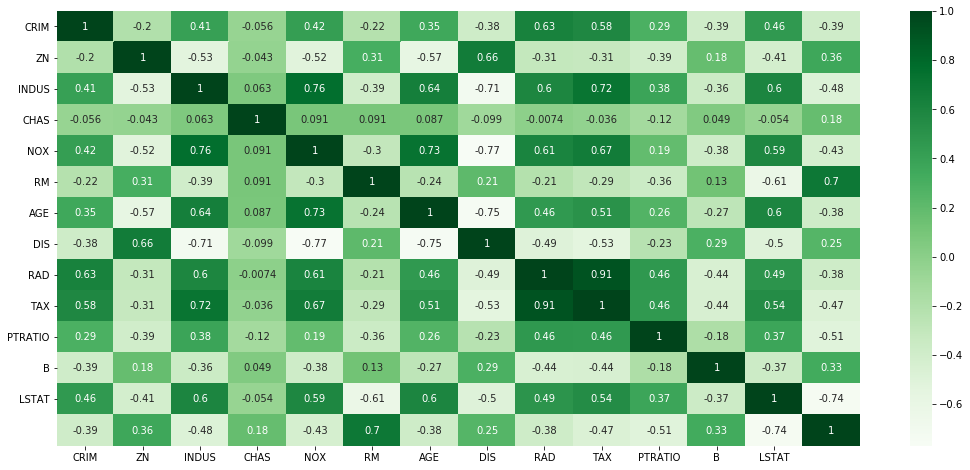

In [380]:
corr = np.corrcoef(data_for_heatmap.T)
plt.figure(figsize = (18,8))
heatmap = sns.heatmap(corr, cmap="Greens", annot=True, 
                      xticklabels=boston.feature_names, 
                      yticklabels=boston.feature_names)

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

In [381]:
corr_with_price = corr[-1][:-1]
most_negative_rel_index = np.argmin(corr_with_price)
most_negative_rel_name = boston.feature_names[most_negative_rel_index]

most_positive_rel_index = np.argmax(corr_with_price)
most_positive_rel_name = boston.feature_names[most_positive_rel_index]

print(f"Most negatively related feature is {most_negative_rel_name}")
print(f"Most positively related feature is {most_positive_rel_name}")

Most negatively related feature is LSTAT
Most positively related feature is RM


In [382]:
def RSS(features, y, all_thresh):
    repeated_f = np.repeat(features.reshape(-1,1), all_thresh.shape[0], axis=1)
    repeated_y = np.repeat(y.reshape(-1,1), all_thresh.shape[0], axis=1)
    repeated_t = np.repeat(all_thresh.reshape(-1,1), features.shape[0], axis=1)
    
    masked_left = ma.masked_where(repeated_f <= repeated_t.T, repeated_y)
    left_mean = np.mean(masked_left, axis=0)
    left_sum = np.sum((masked_left-left_mean)**2, axis=0)

    masked_right = ma.masked_where(repeated_f > repeated_t.T, repeated_y)
    right_mean = np.mean(masked_right, axis=0)
    right_sum = np.sum((masked_right-right_mean)**2, axis=0)
    
    return left_sum + right_sum


In [383]:
rss_positive = RSS(train_x.T[most_positive_rel_index], train_y, np.unique(train_x.T[most_positive_rel_index]))
rss_negative = RSS(train_x.T[most_negative_rel_index], train_y, np.unique(train_x.T[most_negative_rel_index]))
thr_positive = np.unique(train_x.T[most_positive_rel_index])
thr_negative = np.unique(train_x.T[most_negative_rel_index])

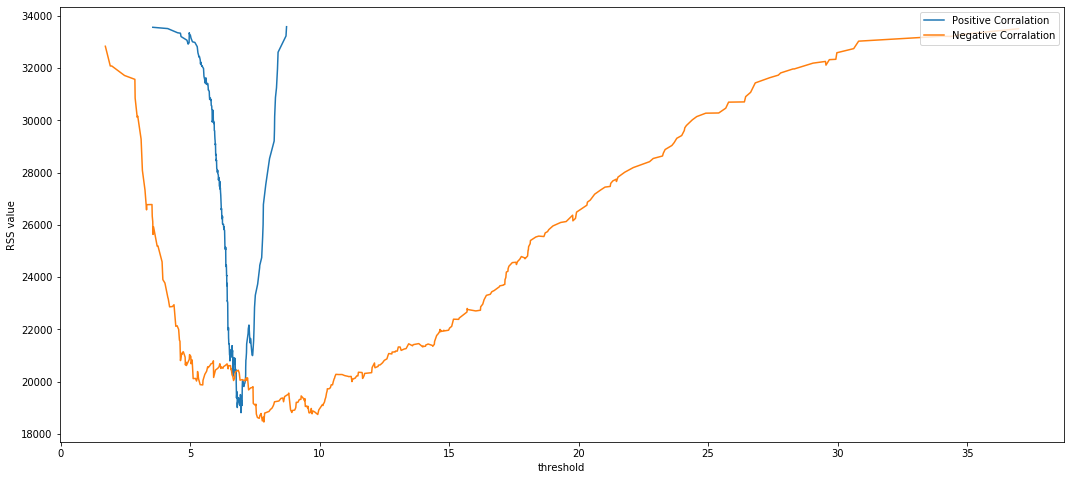

In [384]:
plt.figure(figsize = (18,8))
plt.plot(thr_positive, rss_positive, label="Positive Corralation")
plt.plot(thr_negative, rss_negative, label="Negative Corralation")
plt.legend(loc="upper right")
plt.xlabel("threshold")
plt.ylabel("RSS value")
plt.show()

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [391]:
class RegressionTree():    

    class Node():
        def __init__(self):
            self.right = None
            self.left = None
            self.attr_index = None
            self.threshold = None
            self.is_terminal = False
            self.value = None
    
    def __init__(self, feature_names=None, max_depth=3):
        self.root = self.Node()
        self.feature_names = feature_names
        self.max_depth = max_depth
        
    def __print(self, current_node, depth=0):
        if current_node is None:
            return
        print("---" * depth + ">", 
              self.feature_names[current_node.attr_index][0][0] + " - thr: " + str(current_node.threshold) if not current_node.is_terminal else "",
              "* " + str(current_node.value) if current_node.is_terminal else "")
        self.__print(current_node.left, depth+1)
        self.__print(current_node.right, depth+1)
        
    def find_partition(self, current_node, x):
        if current_node.is_terminal:
            return current_node.value
        next_node = current_node.left if x[:, current_node.attr_index] < current_node.threshold else current_node.right
        return self.find_partition(next_node, x)
        
    def __predict(self, x):
        return self.find_partition(self.root, x)
    
    def rss(self, features, y, all_thresh):
        repeated_f = np.repeat(features.reshape(-1,1), all_thresh.shape[0], axis=1)
        repeated_y = np.repeat(y.reshape(-1,1), all_thresh.shape[0], axis=1)
        repeated_t = np.repeat(all_thresh.reshape(-1,1), features.shape[0], axis=1)
        
        masked_left = ma.masked_where(repeated_f < repeated_t.T, repeated_y)
        left_mean = np.mean(masked_left, axis=0).data
        left_sum = np.sum((masked_left-left_mean)**2, axis=0).data

        masked_right = ma.masked_where(repeated_f >= repeated_t.T, repeated_y)
        right_mean = np.mean(masked_right, axis=0).data
        right_sum = np.sum((masked_right-right_mean)**2, axis=0).data
        
        return left_sum + right_sum

    def find_best_feature(self, x, y):
        num_feature = x.shape[1]
        rss_for_all_features = []
        for idx in range(num_feature):
            related_feature = x[:, idx]
            all_thresh = np.unique(related_feature)

            all_rss = self.rss(related_feature, y, all_thresh)

            min_rss = np.min(all_rss)
            min_rss_thresh = all_thresh[np.argmin(all_rss)]        

            rss_for_all_features.append((min_rss, min_rss_thresh))

        min_idx = np.argmin(rss_for_all_features, axis=0)[0]
        thr = rss_for_all_features[min_idx][1]
        return min_idx, thr
    
    def build_tree(self, current_node, x, y, current_depth=0):
        if len(y) == 0:
            return None
        if current_depth == self.max_depth or x.shape[1] == 0 or x.shape[0] == 1 or np.unique(y).shape[0] == 1:
            current_node.is_terminal = True
            current_node.value = np.mean(y)
            return current_node
            
        index, thr = self.find_best_feature(x, y)
        
        left_x = x[x.T[index] < thr]
        left_y = y[x.T[index] < thr]
        right_x = x[x.T[index] >= thr]
        right_y = y[x.T[index] >= thr]
        
        
        current_node.feature_name = self.feature_names[index]
        current_node.attr_index = np.argwhere(self.feature_names == self.feature_names[index])
        current_node.threshold = thr
 
        current_node.left = self.build_tree(self.Node(), left_x, left_y, current_depth+1)
        current_node.right = self.build_tree(self.Node(), right_x, right_y, current_depth+1)
        
        if current_node.left is None:
            current_node = current_node.right
        elif current_node.right is None:
            current_node = current_node.left
                
        return current_node
        
    def fit(self, x, y):
        self.build_tree(self.root, x, y, current_depth=0)
        
    def predict(self, x):
        return np.array([self.__predict(elem.reshape(-1,1).T) for elem in x])
    
    def visualize(self):
        self.__print(self.root)
        

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In [396]:
regression_tree = RegressionTree(boston.feature_names, 3)
regression_tree.fit(train_x, train_y)

In [397]:
preds = regression_tree.predict(test_x)
r2_score(test_y, preds)

0.7689393540267331

In [388]:
regression_tree.visualize()

> LSTAT - thr: 7.88 
---> RM - thr: 7.454 
------> DIS - thr: 1.6132 
--------->  * 50.0
--------->  * 27.90098039215686
------> CRIM - thr: 3.47428 
--------->  * 45.80434782608695
--------->  * 21.9
---> LSTAT - thr: 15.02 
------> DIS - thr: 1.2852 
--------->  * 50.0
--------->  * 21.374834437086093
------> NOX - thr: 0.659 
--------->  * 17.116363636363637
--------->  * 11.9984375


## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [389]:
train_splits_x = np.array_split(train_x, 5)
train_splits_y = np.array_split(train_y, 5)
configs = {}
for m_depth in [3,4,5,6,7,8,9,10]:
    configs[m_depth] = []
    for i in range(5):
        train_set_x, train_set_y, val_set_x, val_set_y = [], [], [], []
        for j in range(5):
            if i != j:
                train_set_x.extend(train_splits_x[j])
                train_set_y.extend(train_splits_y[j])
            else:
                val_set_x.extend(train_splits_x[j])
                val_set_y.extend(train_splits_y[j])
                
        train_set_x, train_set_y = np.array(train_set_x), np.array(train_set_y)
        val_set_x, val_set_y = np.array(val_set_x), np.array(val_set_y)
        
        regression_tree = RegressionTree(boston.feature_names, m_depth)
        regression_tree.fit(train_set_x, train_set_y)
        preds = regression_tree.predict(val_set_x)
        r2 = r2_score(val_set_y, preds)
        configs[m_depth].append(r2)   
        

In [390]:
print("R2 scores")
for k, v in configs.items():
    print(f"For depth {k}, Mean is {np.mean(v)}, Std is {np.std(v)}")

R2 scores
For depth 3, Mean is 0.5998006481102686, Std is 0.11578577220615159
For depth 4, Mean is 0.6767188852914612, Std is 0.12206324164548961
For depth 5, Mean is 0.7038521059536594, Std is 0.11080607577408821
For depth 6, Mean is 0.7104589728611181, Std is 0.11392128463374557
For depth 7, Mean is 0.6887905818128918, Std is 0.11095650407498059
For depth 8, Mean is 0.6851533624231498, Std is 0.11669302201618949
For depth 9, Mean is 0.6802301647016036, Std is 0.11562684948280337
For depth 10, Mean is 0.6734907019072004, Std is 0.11503533402994903


**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

# Selected Depth Is: 7 

In [398]:
regression_tree = RegressionTree(boston.feature_names, max_depth=7)
regression_tree.fit(train_x, train_y)
preds = regression_tree.predict(test_x)
r2_score(test_y, preds)

0.8691116909175505

# Train and test scores of different depths

In [400]:
for i in range(3,11):
    regression_tree = RegressionTree(boston.feature_names, max_depth=i)
    regression_tree.fit(train_x, train_y)
    preds = regression_tree.predict(test_x)
    test_r2 = r2_score(test_y, preds)
    preds = regression_tree.predict(train_x)
    train_r2 = r2_score(train_y, preds)
    print(f"For depth {i}, train r2 is {train_r2}, test r2 is {test_r2}")

For depth 3, train r2 is 0.813543307594928, test r2 is 0.7689393540267331
For depth 4, train r2 is 0.8792804515594841, test r2 is 0.8823292928707149
For depth 5, train r2 is 0.917766759089849, test r2 is 0.8487502195655853
For depth 6, train r2 is 0.9421790670387243, test r2 is 0.8542762036324614
For depth 7, train r2 is 0.9584978752375841, test r2 is 0.8691116909175505
For depth 8, train r2 is 0.9719646023814232, test r2 is 0.8529199719045201
For depth 9, train r2 is 0.9799925158928954, test r2 is 0.8521944601477849
For depth 10, train r2 is 0.9855076236887335, test r2 is 0.849630097400405
